In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from mahotas.features import haralick
import imgaug.augmenters as iaa
from skimage.exposure import equalize_hist
from mahotas.features import haralick
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # Import to_categorical function
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

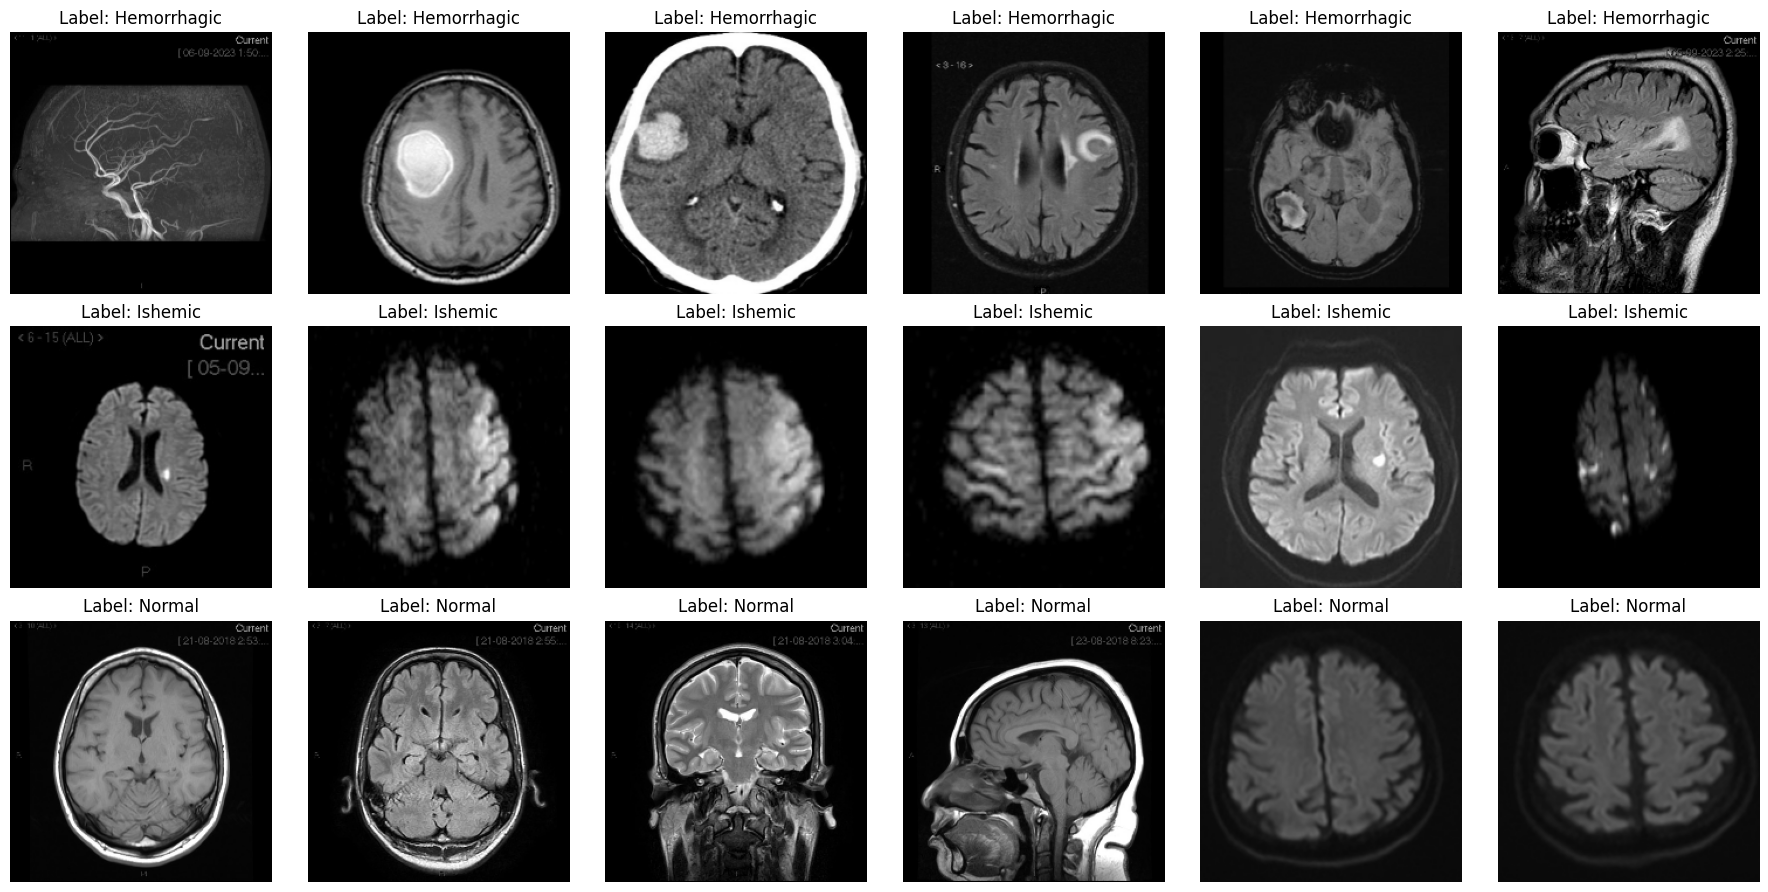

Label: Hemorrhagic, Haralick: [ 1.45639106e-01  1.75450472e+02  9.36720835e-01  1.38630584e+03
  5.15428489e-01  7.37613306e+01  5.36977287e+03  5.37930791e+00
  7.64085287e+00  8.37377272e-04  3.45910887e+00 -3.70518889e-01
  9.84091026e-01], Entropy: 4.67
Label: Ishemic, Haralick: [ 4.23371671e-01  1.65142575e+02  9.61941943e-01  2.16872137e+03
  7.15051381e-01  5.36640455e+01  8.50974290e+03  3.53017918e+00
  4.85144162e+00  1.79099969e-03  2.46918931e+00 -4.19544639e-01
  9.60736676e-01], Entropy: 3.05
Label: Normal, Haralick: [ 4.89773395e-02  5.40209407e+02  9.37067242e-01  4.29124324e+03
  4.98039520e-01  1.10722555e+02  1.66247635e+04  6.40094260e+00
  8.75616992e+00  7.34570299e-04  3.80831863e+00 -4.16392104e-01
  9.94772667e-01], Entropy: 5.52


In [6]:
# Normalize image
def normalize_image(img):
    return img / 255.0

# Preprocess image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image to fit VGG16 input size
    img_normalized = normalize_image(img_resized)
    img_3ch = np.stack((img_normalized,)*3, axis=-1)  # Convert to 3 channels
    return img_3ch

# Load and preprocess the dataset
def load_dataset(directories):
    images = []
    labels = []
    for label, directory in directories.items():
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(root, file)
                    img_resized = preprocess_image(image_path)
                    images.append(img_resized)
                    labels.append(label)
    return images, labels

# Calculate features for an image
def calculate_features(image):
    gray_image = image[:, :, 0]  # Extract the first channel (since all channels are the same)
    entropy = shannon_entropy(gray_image)
    gray_image_int = (gray_image * 255).astype(np.uint8)  # Convert back to integer type
    haralick_features = haralick(gray_image_int).mean(axis=0)
    return {"haralick": haralick_features, "entropy": entropy}

# Directory paths
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

# Load and preprocess the dataset
images, labels = load_dataset(directories)

# Convert labels to one-hot encoded vectors
label_map = {"Hemorrhagic": 0, "Ishemic": 1, "Normal": 2}
labels_encoded = [label_map[label] for label in labels]
labels_onehot = to_categorical(labels_encoded)

# Calculate features for all images
features_list = []
for img, label in zip(images, labels):
    features = calculate_features(img)
    features['label'] = label
    features_list.append(features)

# Display the images with labels
def display_images(images, num_images_per_category=6):
    categories = ["Hemorrhagic", "Ishemic", "Normal"]
    fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(num_images_per_category * 3, len(categories) * 3))  # Create a figure with rows for each category and num_images columns
    
    img_count = {category: 0 for category in categories}
    for img, label in images:
        if img_count[label] < num_images_per_category:
            ax = axes[categories.index(label), img_count[label]]
            img_disp = (img * 255).astype(np.uint8)  # Convert to correct depth for display
            ax.imshow(img_disp, cmap='gray')  # Display grayscale image
            ax.set_title(f"Label: {label}")
            ax.axis('off')
            img_count[label] += 1
    
    plt.tight_layout()
    plt.show()

display_images(list(zip(images, labels)))

# Display the first 5 features from each category
categories_displayed = set()
for feature in features_list:
    if feature['label'] not in categories_displayed:
        print(f"Label: {feature['label']}, Haralick: {feature['haralick']}, Entropy: {feature['entropy']:.2f}")
        categories_displayed.add(feature['label'])
        if len(categories_displayed) == 3:
            break

In [7]:
# Split dataset into train (60%), validation (20%), and test (20%) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels_onehot, test_size=0.4, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Load pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Create a new model with VGG16 base
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    np.array(train_images), np.array(train_labels),
    validation_data=(np.array(val_images), np.array(val_labels)),
    epochs=20,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Test accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/20


9/9 [==============================] - 1363s 169s/step - loss: 1.9895 - accuracy: 0.3855 - val_loss: 0.9156 - val_accuracy: 0.6196
Epoch 2/20
9/9 [==============================] - 63s 7s/step - loss: 0.8590 - accuracy: 0.6182 - val_loss: 0.8133 - val_accuracy: 0.6630
Epoch 3/20
9/9 [==============================] - 66s 8s/step - loss: 0.7136 - accuracy: 0.7200 - val_loss: 0.7063 - val_accuracy: 0.7391
Epoch 4/20
9/9 [==============================] - 68s 8s/step - loss: 0.6339 - accuracy: 0.7527 - val_loss: 0.6342 - val_accuracy: 0.7717
Epoch 5/20
9/9 [==============================] - 60s 7s/step - loss: 0.5932 - accuracy: 0.7600 - val_loss: 0.5798 - val_accuracy: 0.8152
Epoch 6/20
9/9 [==============================] - 57s 6s/step - loss: 0.4496 - accuracy: 0.8327 - val_loss: 0.6459 - val_accuracy: 0.7609
Epoch 7/20
9/9 [==============================] - 56s 6s/step - loss: 0.4180 - accuracy: 0.8364 - val_loss: 0.5450 - val_accuracy: 0.7935
Epoch 8/20
9/9 [==========

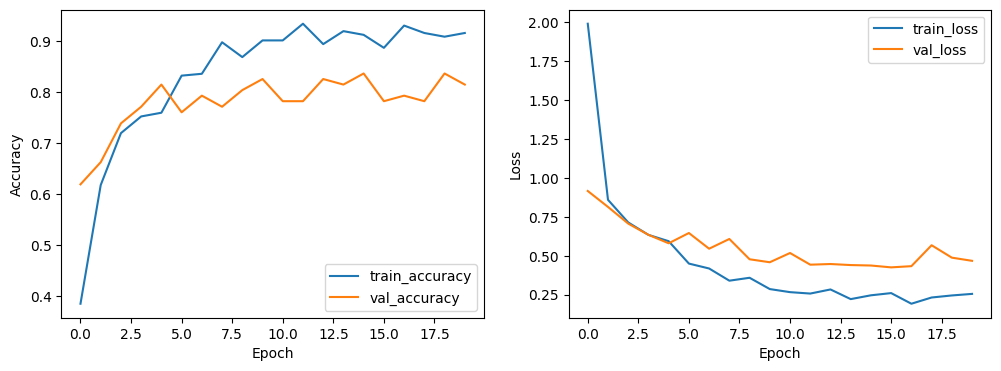

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 [==============================] - 13s 3s/step


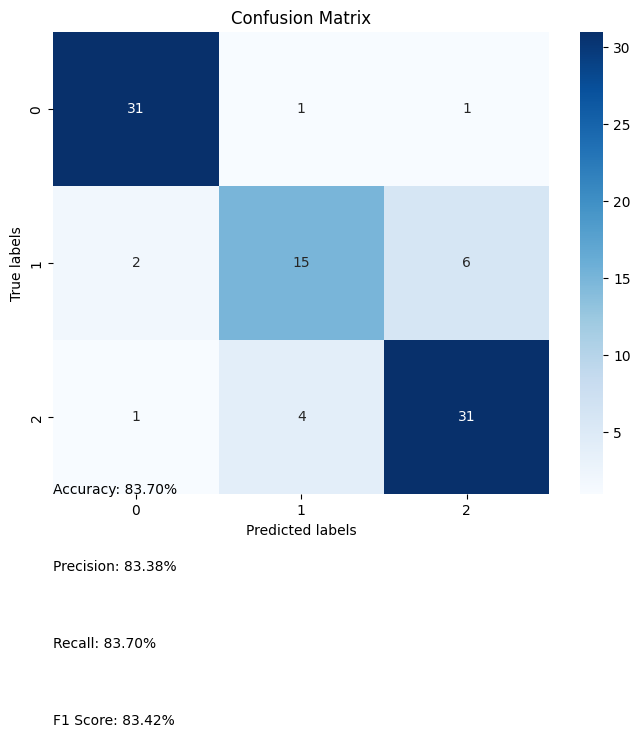

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get the predicted labels for the test set
predicted_labels = model.predict(np.array(test_images))
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert one-hot encoded test labels back to categorical labels
true_labels = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels) * 100
precision = precision_score(true_labels, predicted_labels, average='weighted') * 100
recall = recall_score(true_labels, predicted_labels, average='weighted') * 100
f1 = f1_score(true_labels, predicted_labels, average='weighted') * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Add accuracy, precision, recall, and F1 score to plot
plt.text(0, 3, f'Accuracy: {accuracy:.2f}%', fontsize=10, ha='left')
plt.text(0, 3.5, f'Precision: {precision:.2f}%', fontsize=10, ha='left')
plt.text(0, 4, f'Recall: {recall:.2f}%', fontsize=10, ha='left')
plt.text(0, 4.5, f'F1 Score: {f1:.2f}%', fontsize=10, ha='left')

plt.show()